In [1]:
import numpy as np
import copy
from pprint import pprint
import tqdm

from pymdp.utils import plot_beliefs, plot_likelihood
from pymdp import utils
from pymdp.envs import TMazeEnv, MultiArmedBanditEnv
from pymdp.pdo_agents import PDOAgentGradient, EVAgentGradient, EVAgentDirect, PDOAgentDirect
from pymdp.agent import Agent

import functools
import matplotlib
import matplotlib.pyplot as plt
import shelve, pickle, bz2
_=np.set_printoptions(linewidth=60, precision=3, suppress=False)

In [2]:
reward_probabilities = [1.0, 0.0]
# reward_probabilities = [0.98, 0.02] # probabilities used in the original SPM T-maze demo
env = TMazeEnv(reward_probs=reward_probabilities)

# these are useful for displaying read-outs during the loop over time
reward_conditions = ["Right", "Left"]
location_observations = ['CENTER', 'RIGHT ARM', 'LEFT ARM', 'CUE LOCATION']
location_codes = "0RLC"
reward_observations = ['No reward', 'Reward!', 'Loss!']
cue_observations = ['Cue Right', 'Cue Left']


def obs_text(obs):
    return str((location_observations[obs[0]], reward_observations[obs[1]], cue_observations[obs[2]]))


def counts(vals):
    counts = {}
    for v in vals:
        counts.setdefault(v, 0)
        counts[v] += 1
    return sorted(counts.items(), key=lambda x: x[1], reverse=True)


def shelve_it(file_name):
    d = shelve.open(file_name)

    def decorator(func):
        def new_func(*args, **kwargs):
            # Key is only str reprs of args and kwargs (sorted by key)
            key = str((func.__name__, args, sorted(kwargs.items())))
            if key not in d:
                val = func(*args, **kwargs)
                d[key] = bz2.compress(pickle.dumps(val, protocol=5))
            else:
                val = pickle.loads(bz2.decompress(d[key]))
            return val

        return new_func

    return decorator


@shelve_it("_cache_run_experiment.shelve")
def run_experiment(env, agent_type, t_win=1.0, t_loss=-1.0, t_cue=0.0, reps=100, steps=2, progress=False, reinit_agent=True, show_reps=0, **kwargs):
    rews = []
    loc_obs = []
    def init_agent():
        if agent_type == "EFE":
            agent = init_efe(T=steps, **kwargs)
            agent.stats = {}
        elif agent_type == "PDO":
            agent = init_pdo(T=steps, **kwargs)
        else:
            raise ValueError(f"Unknown agent type: {agent_type}")
        agent.C[1][1] = t_win
        agent.C[1][2] = t_loss
        agent.C[0][3] = t_cue
        return agent
    
    if not reinit_agent:
        # Initialize the agent only once
        agent = init_agent()
        # Let it infer the complete policy (if e.g. PDO agent)
        agent.infer_states(env.reset())
        agent.infer_policies()

    for rep in (bar := tqdm.trange(reps, desc="Sampling runs", disable=not progress, leave=True)):
        if reinit_agent:
            agent = init_agent()
        else:
            agent.reset()

        obs = env.reset()  # reset the environment and get an initial observation
        rew = 0.0
        loc_ob = f"c{'RL'[env.reward_condition]}:{location_codes[obs[0]]}"

        if rep < show_reps:
            bar.write(f"=== New run ({
                      reward_conditions[env.reward_condition]}, observation: {obs_text(obs)} ===")

        for t in range(steps):
            agent.infer_states(obs)
            agent.infer_policies()
            action = agent.sample_action()
            obs = env.step(action)
            if rep < show_reps:
                bar.write(f"[Step {t}] action: [Move to {
                          location_observations[int(action[0])]}], observation: {obs_text(obs)}")

            for i in range(len(agent.C)):
                rew += agent.C[i][obs[i]]
            loc_ob = f"{loc_ob}-{location_codes[obs[0]]}"

        rews.append(float(rew))
        loc_obs.append(loc_ob)
        bar.set_postfix(Umean=np.mean(rews), Ustd=np.std(rews))
    bar.close()

    rews = np.array(rews)

    # print(f"Rewards: {counts(rews)}")
    # print(f"Mean reward of {reps}: {np.mean(rews):.3}, std={np.std(rews):.3}")
    # print(f"Location sequences: {counts(loc_obs)}")

    return agent, rews

PDO_ITERATIONS = 1000
PDO_LR = 1.


def init_efe(sophisticated=False, T=2, **kwargs):
    A_gm = copy.deepcopy(env.get_likelihood_dist())
    B_gm = copy.deepcopy(env.get_transition_dist())
    agent = Agent(A=A_gm, B=B_gm, control_fac_idx=[
                  0], sophisticated=sophisticated, inference_horizon=T, **kwargs)
    agent.D[0] = utils.onehot(0, agent.num_states[0])

    return agent


def init_pdo(ev=False, direct=False, beta=0.0, T=2):
    A_gm = copy.deepcopy(env.get_likelihood_dist())
    B_gm = copy.deepcopy(env.get_transition_dist())
    if ev:
        if direct:
            agent = EVAgentDirect(A=A_gm, B=B_gm, time_horizon=T, env=env)
        else:
            agent = EVAgentGradient(A=A_gm, B=B_gm, time_horizon=T, env=env,
                            policy_lr=PDO_LR, policy_iterations=PDO_ITERATIONS)
    else:
        if direct:
            agent = PDOAgentDirect(A=A_gm, B=B_gm, time_horizon=T, env=env, beta=beta)
        else:
            agent = PDOAgentGradient(A=A_gm, B=B_gm, time_horizon=T, env=env,
                             policy_lr=PDO_LR, beta=beta, policy_iterations=PDO_ITERATIONS)
    agent.D[0] = utils.onehot(0, agent.num_states[0])
    return agent


  0%|          | 0/21 [00:00<?, ?it/s]

PDO, $\beta$=1.0: 100%|██████████| 21/21 [00:00<00:00, 3603.21it/s]


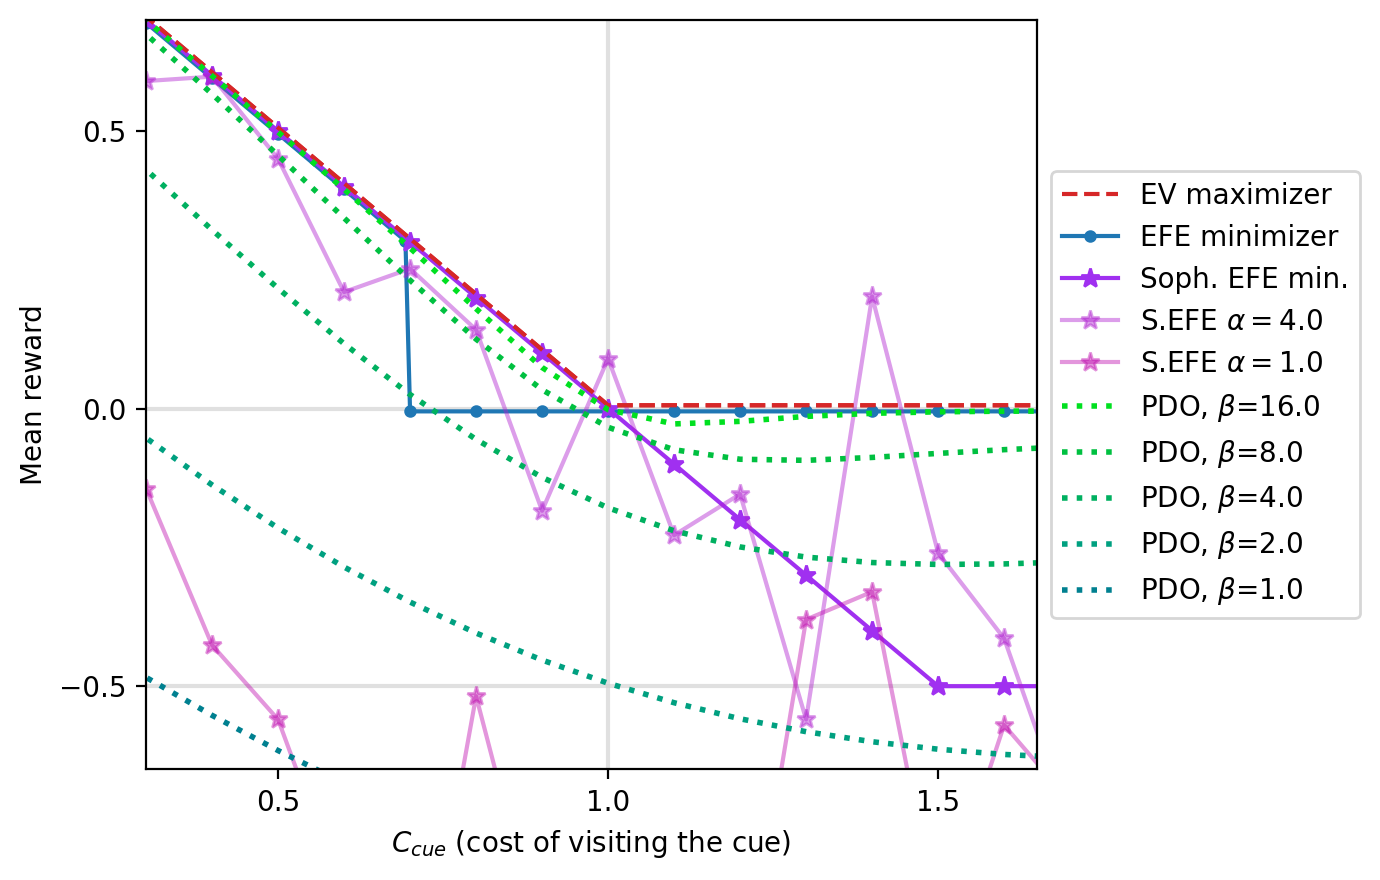

In [3]:
T = 2
REPS = 3
T_LOSS = -4.0

# X = np.concatenate([[-0.4, -0.35, -0.3, -0.25], np.arange(-0.2, 0.5, 0.05),
#                    np.arange(0.5, 1.0, 0.02), np.arange(1.0, 1.901, 0.05)])
X = np.arange(-0.2, 1.9, 0.1)
X_EFE = np.array(sorted(list(X)+[0.693]))
X_EFE2 = np.array(sorted(list(X_EFE)+[0.65, 0.675]))

def do_the_plot(label, agent_type, color=None, reps=REPS, offset=0, override=None, style="-", X=X, linewidth=1.5, markersize=7, background=False, **kwargs):
    # offset *= 0.013
    Y = np.zeros_like(X)
    Ystd = np.zeros_like(X)
    for i in tqdm.trange(len(X), desc=label, leave=True):
        _reps = reps
        if callable(reps):
            _reps = reps(X[i])
        ag, rws = run_experiment(env, agent_type, reps=_reps, steps=T, show_reps=0, t_loss=T_LOSS,
                                 reinit_agent=(agent_type == "EFE"), progress=False, t_cue=-X[i], **kwargs)
        Y[i] = np.mean(rws)
        if agent_type == "PDO":
            Y[i] = ag.stats["EV"]
        Ystd[i] = np.std(rws)
        if override is not None:
            Y[i] = override(X[i], Y[i])
    # Plot the results with error bars
    # if agent_type == "EFE":
    #     plt.errorbar(X-offset*0.01, Y-offset*0.005, yerr=Ystd/10, fmt="-", label=label, color=color)
    plt.plot(X-offset*0.0, Y-offset*0.01, style, label=label, color=color, linewidth=linewidth, markersize=markersize)
    if background:
        plt.plot(X-offset*0.0, Y-offset*0.01, "-", label=None, color=color, linewidth=linewidth, markersize=0, alpha=0.3)


plt.figure(figsize=(7, 4.5), dpi=200)
plt.hlines([-0.5,0,1], -10, 10, linestyle="-", color="#ccc9")
plt.vlines([0,1], -10, 10, linestyle="-", color="#ccc9")

# Select the set matplotlib palette
palette = plt.get_cmap('tab10')

do_the_plot("EV maximizer", "PDO", palette.colors[3], ev=True, direct=True, offset=-0.6, style="--")

do_the_plot("EFE minimizer", "EFE", "#1f77b4", sophisticated=False, offset=0.5, style=".-", X=X_EFE)
# COLORS = ["#2080e0a0", "#4050e0a0", "#6030e090"]
# for i, beta in enumerate([4.0, 2.0, 1.0]):
#     if beta != 2.0:
#         do_the_plot(f"EFE, $\\alpha={beta}$", "EFE", COLORS[i], sophisticated=False, offset=0.5, action_selection="stochastic",
#                     alpha=beta, reps=lambda x: 10000 if x > 0.5 and x < 0.8 else 1000, style=".-", X=X_EFE2)

do_the_plot("Soph. EFE min.", "EFE", "#a030f0", sophisticated=True, override=lambda x, y: y if x < 1.5 else -0.5, offset=0, style="*-")
COLORS = ["#b020d070", "#c010b070"]
for i, beta in enumerate([4.0, 1.0]):
    do_the_plot(f"S.EFE $\\alpha={beta}$", "EFE", COLORS[i], sophisticated=True, offset=-1, action_selection="stochastic", alpha=beta, reps=50, style="*-")

# Again for visibility
do_the_plot(None, "PDO", palette.colors[3], ev=True, direct=True, offset=-0.6, style="--")


# COLORS = ["#a07000", "#509040", "#00b060", "#00a080", "#008090", ]
COLORS = ["#00e020", "#00c040", "#00b060", "#00a080", "#008090", ]
for i, beta in enumerate([16.0, 8.0, 4.0, 2.0, 1.0]):
    do_the_plot(f"PDO, $\\beta$={beta:.3}", "PDO", style=":",
                color=COLORS[i], ev=False, direct=True, beta=beta, offset=0, linewidth=2, background=False)

plt.xlabel("$C_{cue}$ (cost of visiting the cue)")
plt.ylabel("Mean reward")
# plt.ylim(-2.4, 1.2)
# plt.xlim(-0.2, 1.7)
plt.xticks(np.arange(-5, 5, 0.5))
plt.yticks(np.arange(-5, 5, 0.5))
plt.ylim(-0.65, 0.7)
plt.xlim(0.3, 1.65)
# Legend is too big for the figure, place it outside to the right
plt.legend(loc="center left", bbox_to_anchor=(1.0, 0.5))
plt.tight_layout()
plt.savefig("ev.pdf")
plt.show()

PDO, $\beta$=0.0: 100%|██████████| 44/44 [00:00<00:00, 3841.34it/s]


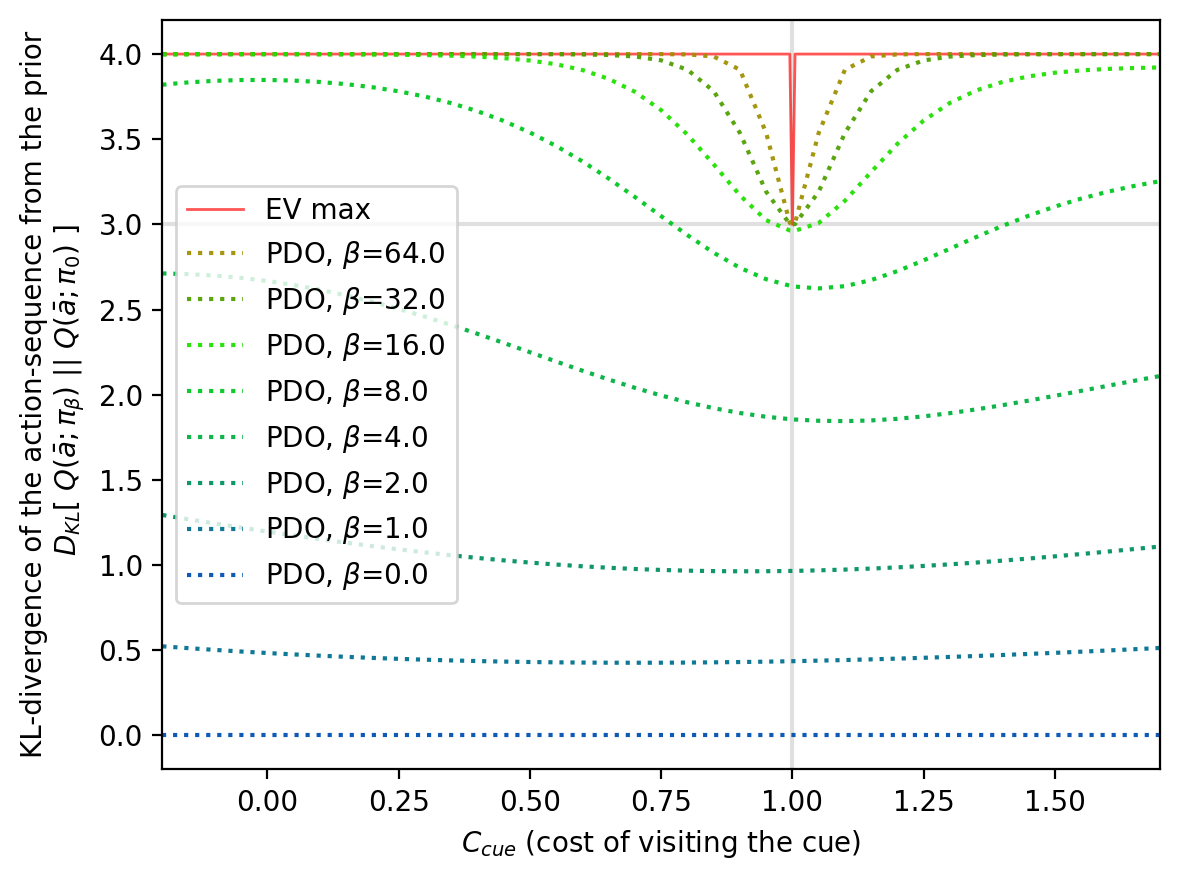

In [4]:
X = np.array(sorted(list(np.arange(-0.2, 1.9, 0.05))+[0.995, 1.005]))
Y = np.zeros_like(X)
Ystd = np.zeros_like(X)


def do_the_plot(label, agent_type, style=":", color=None, reps=REPS, offset=0, override=None, linewidth=1.5, markersize=7, **kwargs):
    offset *= 0.0
    for i in tqdm.trange(len(X), desc=label, leave=True):
        _reps = reps
        if callable(reps):
            _reps = reps(X[i])
        ag, rws = run_experiment(env, agent_type, reps=_reps, steps=T, show_reps=0, t_loss=T_LOSS,
                                 reinit_agent=(agent_type == "EFE"), progress=False, t_cue=-X[i], **kwargs)
        Y[i] = np.mean(rws)
        if agent_type == "PDO":
            Y[i] = ag.stats["policy_KL"]
        Ystd[i] = np.std(rws)
        if override is not None:
            Y[i] = override(X[i], Y[i])
    # Plot the results with error bars
    # plt.errorbar(X+x_offset, Y, yerr=Ystd/10, fmt=".-", label=label, color=color)
    plt.plot(X, Y-offset, style, label=label, color=color, linewidth=linewidth, markersize=markersize)


plt.figure(figsize=(6, 4.5), dpi=200)
plt.hlines([3.0], -10, 10, linestyle="-", color="#ccc9")
plt.vlines([1], -10, 10, linestyle="-", color="#ccc9")

# Select the set matplotlib palette
palette = plt.get_cmap('tab10')

# do_the_plot("EV maximizer", "PDO", palette.colors[3], ev=True, direct=True, offset=0)

# do_the_plot("EFE", "EFE", palette.colors[0], sophisticated=False, offset=1)

# do_the_plot("Soph. EFE", "EFE", palette.colors[4],
#             sophisticated=True,
#             # reps=lambda p: 1 if p < 1.4 else 1000,
#             override=lambda x, y: y if x < 1.5 else -0.5,
#             offset=2)

do_the_plot(f"EV max", "PDO", color="#f00a", style="-", ev=True, direct=True, beta=None, offset=0, linewidth=1)

COLORS = ["#a09000f0", "#50a000f0", "#20e000f0", "#00c720f0", "#00b040f0", "#009060f0", "#007090f0", "#0050b0f0"]
for i, beta in enumerate([64.0, 32.0, 16.0, 8.0, 4.0, 2.0, 1.0, 0.0]):
    do_the_plot(f"PDO, $\\beta$={beta:.3}", "PDO",
                color=COLORS[i], ev=False, direct=True, beta=beta, offset=0)


plt.xlabel("$C_{cue}$ (cost of visiting the cue)")
# plt.ylabel("KL-divergence of the action-sequence from the prior\n$\\ D_{KL}[\\ Q(a_{0:T};\\pi)\\ ||\\ Q(a_{0:T},\\pi_0)\\ ]$")
plt.ylabel("KL-divergence of the action-sequence from the prior\n$\\ D_{KL}[\\ Q(\\bar{a};\\pi_\\beta)\\ ||\\ Q(\\bar{a};\\pi_0)\\ ]$")
plt.ylim(-0.2, 4.2)
plt.xlim(-0.2, 1.7)

plt.tight_layout()
plt.legend(loc="center left")
plt.savefig("policy_KL.pdf")
plt.show()

PDO, $\beta$=0.0: 100%|██████████| 44/44 [00:00<00:00, 3158.25it/s]


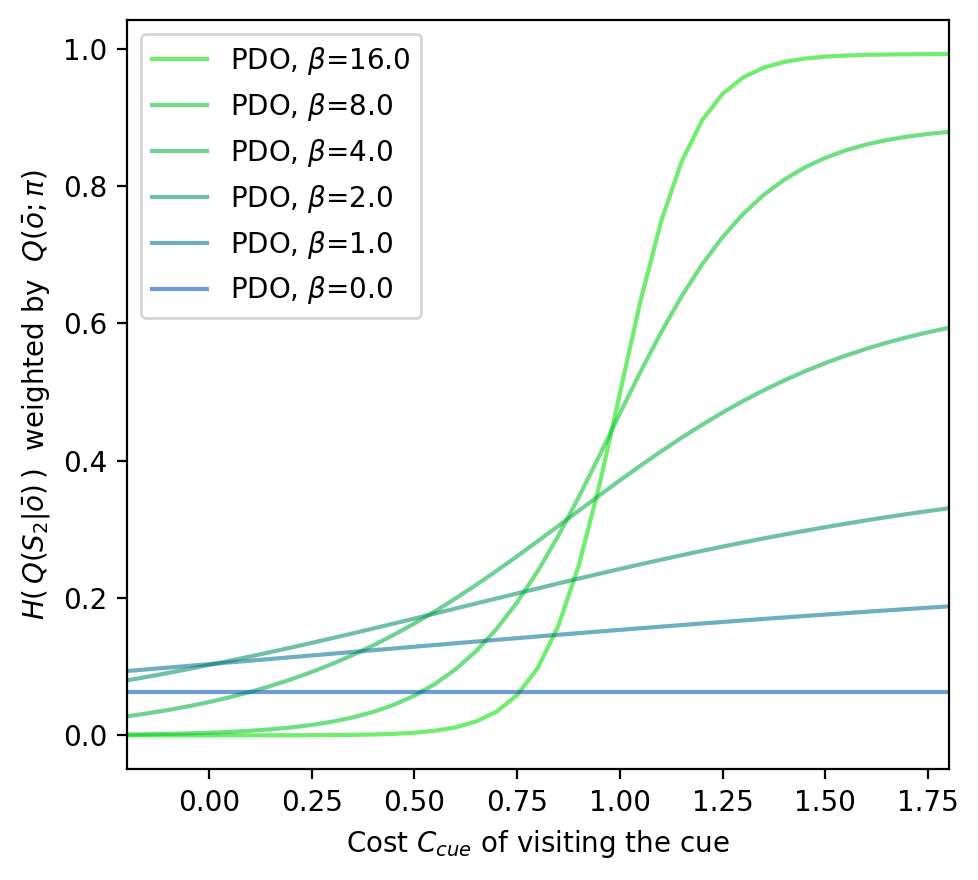

In [5]:
Y = np.zeros_like(X)
Ystd = np.zeros_like(X)


def do_the_plot(label, agent_type, color=None, reps=REPS, offset=0, **kwargs):
    offset *= 0.0
    Y = np.zeros_like(X)
    Ystd = np.zeros_like(X)
    for i in tqdm.trange(len(X), desc=label, leave=True):
        _reps = reps
        if callable(reps):
            _reps = reps(X[i])
        ag, rws = run_experiment(env, agent_type, reps=_reps, steps=T, show_reps=0, t_loss=T_LOSS,
                                 reinit_agent=(agent_type == "EFE"), progress=False, t_cue=-X[i], **kwargs)
        Y[i] = np.mean(rws)
        if agent_type == "PDO":
            Y[i] = ag.stats["state_H"][2]
        Ystd[i] = np.std(rws)
    # Plot the results with error bars
    # plt.errorbar(X+x_offset, Y, yerr=Ystd/10, fmt=".-", label=label, color=color)
    plt.plot(X, Y-offset, "-", label=label, color=color)


plt.figure(figsize=(5, 4.5), dpi=200)

# Select the set matplotlib palette
palette = plt.get_cmap('tab10')

# do_the_plot("EV maximizer", "PDO", palette.colors[3], ev=True, direct=True, offset=0)

# do_the_plot("EFE", "EFE", palette.colors[0], sophisticated=False, offset=1)

# do_the_plot("Soph. EFE", "EFE", palette.colors[4],
#             sophisticated=True,
#             # reps=lambda p: 1 if p < 1.4 else 1000,
#             override=lambda x, y: y if x < 1.5 else -0.5,
#             offset=2)

COLORS = ["#00e00090", "#00c72090", "#00b04090", "#00906090", "#00709090", "#0050b090"]
for i, beta in enumerate([16.0, 8.0, 4.0, 2.0, 1.0, 0.0]):
    do_the_plot(f"PDO, $\\beta$={beta:.3}", "PDO",
                color=COLORS[i], ev=False, direct=True, beta=beta, offset=i+3)

plt.xlabel("Cost $C_{cue}$ of visiting the cue")
# plt.ylabel("$\\mathbf{E}_{Q(\\bar{o};\\pi)}\\ D_{KL}[\\ \\pi(\\bar{o})\\ ||\\ \\pi_0(\\bar{o})\\ ]$")
plt.ylabel("$H(\\,Q(S_2|\\bar{o})\\,)\\ $ weighted by $\\ Q(\\bar{o}; \\pi)$")
# plt.ylim(-0.9, 1.3)
plt.xlim(-0.2, 1.8)

plt.tight_layout()
plt.legend()
plt.savefig("S_2_H.pdf")
plt.show()